# Load Data

In [104]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [105]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 200

In [106]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [107]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 10
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 250

In [108]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

learning_rate,▁▁
train_accuracy,▁▁
train_auc,▁▁
train_loss,▁▁
train_precision,▁▁
val_accuracy,▁▁
val_auc,▁▁
val_loss,▁▁
val_precision,▁▁
learning_rate,0.00488
train_accuracy,0.26979


In [109]:
device = torch.device(CFG.device)

# Load train data

In [110]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv')).sample(frac=1).reset_index(drop=True)
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,13810,13819,17340_right,0
1,22083,22097,27852_right,0
2,27552,27568,34901_left,4
3,15987,15997,20070_right,0
4,16171,16181,20273_right,0
...,...,...,...,...
35103,16850,16861,21138_right,0
35104,6265,6269,7883_right,3
35105,11284,11291,14181_right,0
35106,860,861,1042_right,0


In [111]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [112]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [113]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
train_data.level.value_counts()

level
0    250
4    250
3    250
2    250
1    250
Name: count, dtype: int64

# Dataset

In [114]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [115]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    v2.RandomRotation(degrees=(0, 90)),  # Random rotation between 0 and 360 degrees
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [116]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

Traceback (most recent call last):
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/co

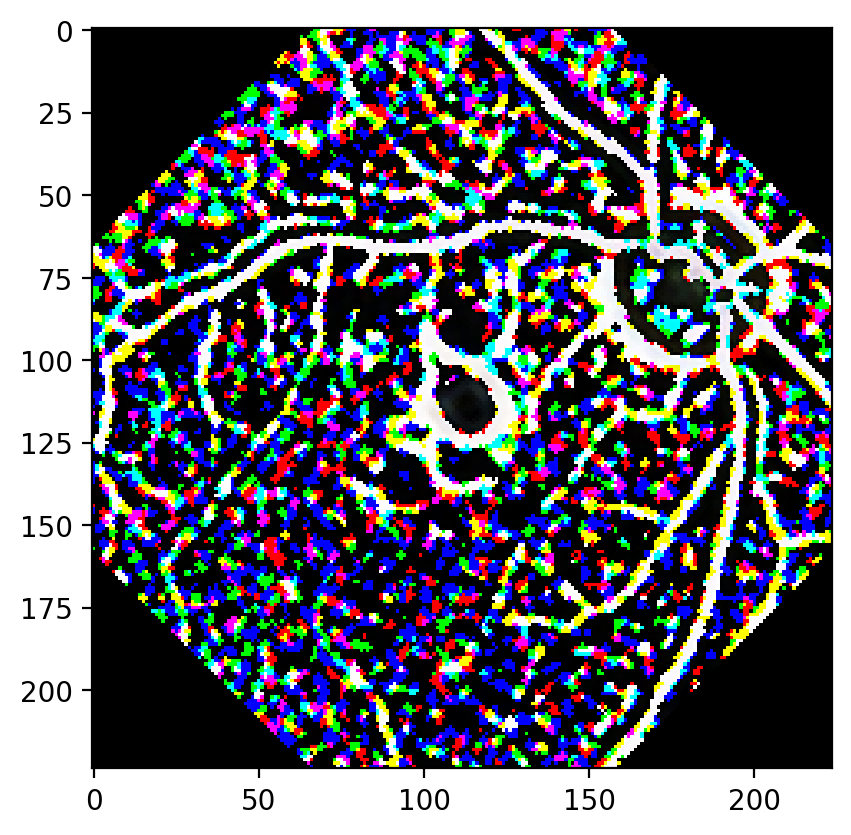

In [117]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

# Metric

In [118]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

In [119]:
# def find_best_threshold(targets, predictions):
#     score_5 = sklearn_f1(targets, predictions > 0.5)
#     best_score = 0
#     best_th = -1
#     for i in range(100):
#         threshold =  i/100
#         _score = sklearn_f1(targets, predictions > threshold)
#         if _score > best_score:
#             best_score = _score
#             best_th = threshold

#     tn, fp, fn, tp = confusion_matrix(targets.numpy(), predictions.numpy() > best_th).ravel()
#     print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
#     return score_5, best_score, best_th

# Train and evaluate functions

In [120]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [121]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [122]:
def evaluate_model(cfg, model, data_loader, loss_criterion, epoch=-1):
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            logits = model(images)

            loss = loss_fn(logits, target)
            val_loss += loss.item()

            targets.append(target.detach().cpu())
            predictions.append(logits.detach().cpu())
            del images, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)

    val_loss /= total_len
    # base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: validation loss = {val_loss:.4f} auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return val_loss, roc_auc, accuracy, precision

In [129]:
def train_epoch(cfg, model, train_loader, loss_criterion, optimizer, scheduler, epoch):
    # scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, (images, labels) in tk0:
        images = images.to(device, non_blocking=True)
        target = labels.to(device, non_blocking=True)

        logits = model(images)
        loss = loss_fn(logits, target)

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        # scaler.step(optimizer)
        # scaler.update()
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del images, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)
    
    display(probabilities.shape)
    display(probabilities)

    train_loss /= total_len
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: training loss = {train_loss:.4f} auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return train_loss, learning_rate_history, roc_auc, accuracy, precision

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='level', ylabel='Count'>

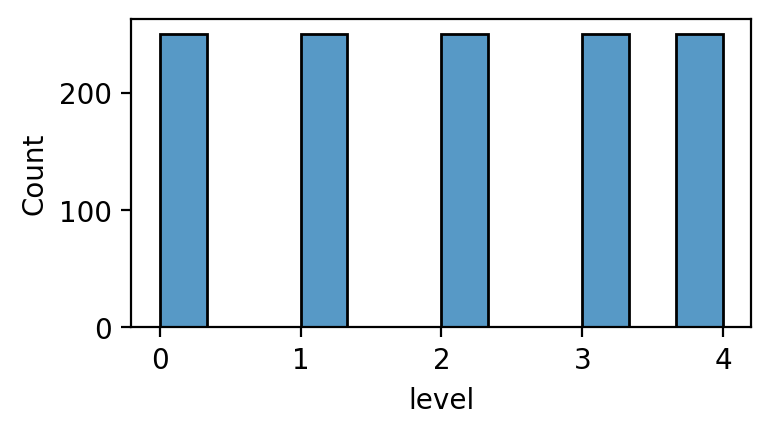

In [130]:
plt.figure(figsize=(4,2))
sns.histplot(train_data["level"])

In [131]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image"].values, train_data["level"].values)):
    train_data.loc[test_index, "fold"] = i

In [132]:
def create_model():
    model = timm.create_model(CFG.model_name, num_classes=NUM_CLASSES, pretrained=True)

#     model = models.resnet50(models.ResNet50_Weights.SENTINEL2_ALL_DINO)
#     wd = torch.concat([model.conv1.weight[:, :13, ...], model.conv1.weight[:, :7, ...]], dim=1)
#     model.conv1 = nn.Conv2d(20, 64, 7, 2, 3, bias=False)
#     model.conv1.weight = nn.Parameter(wd)
#     model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

    return model.to(device)

In [133]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()
    
    # remove the last layer (fc) of model to obtain embeddings
    model = nn.Sequential(*list(model.children())[:-1])
    
    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # store the embeddings for future use
    torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


def plot_tsne(embeddings, labels):
    # Apply t-SNE to the embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings.numpy())

    # Define the number of unique labels/classes
    num_classes = len(np.unique(labels.numpy()))
    # Create a custom color map with specific color transitions
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=num_classes)

    # Create a boundary norm with boundaries and colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 0.5, 1), cmap.N)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
    colorbar.set_label('Severity Level')
    colorbar.set_ticklabels(np.arange(num_classes))  # Set discrete labels if needed
    plt.title('t-SNE of Image Embeddings with Discrete Severity Levels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.savefig(os.path.join(wandb.run.dir, f"tsne.png"), dpi=300)


## Train folds

Model parameters: 23_518_277


Epoch 0 training 15/15 [LR 0.004878] - loss: 1.6040: 100%|███████████████| 15/15 [01:03<00:00,  4.24s/it]


torch.Size([960, 5])

tensor([[0.1911, 0.2017, 0.2091, 0.2091, 0.1890],
        [0.1838, 0.1947, 0.2318, 0.2119, 0.1778],
        [0.1946, 0.1853, 0.2208, 0.2031, 0.1962],
        ...,
        [0.2277, 0.1290, 0.2029, 0.1706, 0.2698],
        [0.1181, 0.0821, 0.1562, 0.1866, 0.4570],
        [0.2541, 0.1851, 0.2320, 0.1813, 0.1474]])

Epoch 0: training loss = 1.6040 auc = 0.5604 accuracy = 0.2490 precision = 0.2683


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.87s/it]
/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: validation loss = 1.6047 auc = 0.5429 accuracy = 0.2000 precision = 0.1582
New best score: 0.0000 -> 0.5429


Epoch 1 training 15/15 [LR 0.004523] - loss: 1.4328: 100%|███████████████| 15/15 [01:01<00:00,  4.10s/it]


torch.Size([960, 5])

tensor([[0.2504, 0.1429, 0.2153, 0.2222, 0.1692],
        [0.2784, 0.1621, 0.2454, 0.2062, 0.1079],
        [0.2536, 0.1842, 0.1912, 0.2174, 0.1536],
        ...,
        [0.0374, 0.0537, 0.1200, 0.3790, 0.4099],
        [0.1430, 0.6332, 0.1589, 0.0539, 0.0110],
        [0.0385, 0.0540, 0.0963, 0.2202, 0.5910]])

Epoch 1: training loss = 1.4328 auc = 0.6910 accuracy = 0.3375 precision = 0.3194


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.01s/it]

Epoch 1: validation loss = 2.3966 auc = 0.5412 accuracy = 0.2640 precision = 0.1579



/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 2 training 15/15 [LR 0.003970] - loss: 1.3480: 100%|███████████████| 15/15 [01:02<00:00,  4.14s/it]


torch.Size([960, 5])

tensor([[0.0876, 0.1062, 0.1287, 0.1940, 0.4835],
        [0.1905, 0.2209, 0.3232, 0.2108, 0.0547],
        [0.2266, 0.2302, 0.3123, 0.1670, 0.0639],
        ...,
        [0.1968, 0.2836, 0.2349, 0.2402, 0.0444],
        [0.3552, 0.3640, 0.1969, 0.0766, 0.0074],
        [0.1030, 0.1791, 0.1856, 0.3390, 0.1933]])

Epoch 2: training loss = 1.3480 auc = 0.7435 accuracy = 0.3885 precision = 0.3789


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.65s/it]


Epoch 2: validation loss = 1.5246 auc = 0.6412 accuracy = 0.2920 precision = 0.2862
New best score: 0.5429 -> 0.6412


Epoch 3 training 15/15 [LR 0.003273] - loss: 1.3035: 100%|███████████████| 15/15 [01:00<00:00,  4.07s/it]


torch.Size([960, 5])

tensor([[0.2096, 0.3715, 0.2089, 0.1780, 0.0319],
        [0.0418, 0.0538, 0.0836, 0.1318, 0.6890],
        [0.2735, 0.5160, 0.1572, 0.0496, 0.0037],
        ...,
        [0.4568, 0.2561, 0.2356, 0.0421, 0.0093],
        [0.0393, 0.0564, 0.0706, 0.1096, 0.7241],
        [0.1184, 0.0875, 0.2009, 0.1838, 0.4094]])

Epoch 3: training loss = 1.3035 auc = 0.7517 accuracy = 0.3969 precision = 0.4003


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.04s/it]
/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3: validation loss = 1.3995 auc = 0.7465 accuracy = 0.3840 precision = 0.3451
New best score: 0.6412 -> 0.7465


Epoch 4 training 15/15 [LR 0.002500] - loss: 1.2261: 100%|███████████████| 15/15 [01:01<00:00,  4.12s/it]


torch.Size([960, 5])

tensor([[0.2829, 0.2481, 0.2741, 0.1221, 0.0727],
        [0.2840, 0.2444, 0.2871, 0.1539, 0.0306],
        [0.0194, 0.0271, 0.1482, 0.2930, 0.5122],
        ...,
        [0.0988, 0.1444, 0.1887, 0.2838, 0.2843],
        [0.3790, 0.3548, 0.2012, 0.0536, 0.0114],
        [0.1105, 0.1514, 0.3307, 0.3271, 0.0803]])

Epoch 4: training loss = 1.2261 auc = 0.7860 accuracy = 0.4562 precision = 0.4467


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.89s/it]


Epoch 4: validation loss = 1.3795 auc = 0.7514 accuracy = 0.4040 precision = 0.4692
New best score: 0.7465 -> 0.7514


Epoch 5 training 15/15 [LR 0.001728] - loss: 1.1604: 100%|███████████████| 15/15 [01:02<00:00,  4.14s/it]


torch.Size([960, 5])

tensor([[3.3649e-01, 2.7672e-01, 3.2597e-01, 5.2604e-02, 8.2189e-03],
        [1.7513e-01, 1.8349e-01, 3.6902e-01, 1.8370e-01, 8.8660e-02],
        [2.5244e-04, 9.8472e-04, 2.2908e-02, 7.0056e-01, 2.7530e-01],
        ...,
        [1.3163e-01, 1.8304e-01, 3.5165e-01, 2.5168e-01, 8.1988e-02],
        [5.3340e-03, 1.2730e-02, 8.5851e-02, 3.0449e-01, 5.9160e-01],
        [1.5000e-02, 1.9608e-02, 1.0716e-01, 2.8107e-01, 5.7716e-01]])

Epoch 5: training loss = 1.1604 auc = 0.8059 accuracy = 0.4625 precision = 0.4715


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.90s/it]


Epoch 5: validation loss = 1.3192 auc = 0.7768 accuracy = 0.4040 precision = 0.4124
New best score: 0.7514 -> 0.7768


Epoch 6 training 15/15 [LR 0.001031] - loss: 1.1185: 100%|███████████████| 15/15 [01:01<00:00,  4.09s/it]


torch.Size([960, 5])

tensor([[0.0013, 0.0020, 0.0088, 0.0236, 0.9644],
        [0.0378, 0.0692, 0.0241, 0.0669, 0.8019],
        [0.3402, 0.4653, 0.1425, 0.0453, 0.0066],
        ...,
        [0.0541, 0.0733, 0.1028, 0.1394, 0.6305],
        [0.1352, 0.1514, 0.2607, 0.2018, 0.2508],
        [0.3615, 0.3830, 0.1789, 0.0581, 0.0185]])

Epoch 6: training loss = 1.1185 auc = 0.8233 accuracy = 0.5010 precision = 0.4993


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.03s/it]


Epoch 6: validation loss = 1.5024 auc = 0.7813 accuracy = 0.4080 precision = 0.4645
New best score: 0.7768 -> 0.7813


Epoch 7 training 15/15 [LR 0.000478] - loss: 1.0566: 100%|███████████████| 15/15 [01:02<00:00,  4.17s/it]


torch.Size([960, 5])

tensor([[0.2400, 0.2550, 0.3447, 0.1234, 0.0369],
        [0.4164, 0.2397, 0.2840, 0.0417, 0.0182],
        [0.0421, 0.0711, 0.3687, 0.4326, 0.0854],
        ...,
        [0.1118, 0.1083, 0.4737, 0.2169, 0.0894],
        [0.3401, 0.3555, 0.2692, 0.0282, 0.0070],
        [0.0101, 0.0208, 0.1299, 0.3364, 0.5027]])

Epoch 7: training loss = 1.0566 auc = 0.8427 accuracy = 0.5417 precision = 0.5424


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.93s/it]


Epoch 7: validation loss = 1.1491 auc = 0.8253 accuracy = 0.4920 precision = 0.5005
New best score: 0.7813 -> 0.8253


Epoch 8 training 15/15 [LR 0.000123] - loss: 1.0201: 100%|███████████████| 15/15 [01:00<00:00,  4.07s/it]


torch.Size([960, 5])

tensor([[3.7484e-01, 4.5801e-01, 1.1771e-01, 4.2582e-02, 6.8634e-03],
        [1.0442e-01, 1.0515e-01, 3.1027e-01, 2.2485e-01, 2.5532e-01],
        [2.3560e-01, 2.9568e-01, 3.0410e-01, 1.2061e-01, 4.4016e-02],
        ...,
        [4.2242e-03, 3.8821e-03, 1.6005e-02, 4.7774e-02, 9.2811e-01],
        [4.5121e-01, 4.1263e-01, 1.1538e-01, 1.6712e-02, 4.0644e-03],
        [5.3236e-05, 3.0386e-04, 3.6156e-02, 9.1282e-01, 5.0671e-02]])

Epoch 8: training loss = 1.0201 auc = 0.8521 accuracy = 0.5510 precision = 0.5528


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.87s/it]

Epoch 8: validation loss = 1.1554 auc = 0.8226 accuracy = 0.4880 precision = 0.5096



Epoch 9 training 15/15 [LR 0.000001] - loss: 0.9976: 100%|███████████████| 15/15 [01:02<00:00,  4.17s/it]


torch.Size([960, 5])

tensor([[2.0791e-01, 2.8879e-01, 3.6651e-01, 1.1884e-01, 1.7952e-02],
        [2.1387e-05, 5.2990e-05, 2.6053e-02, 5.9982e-01, 3.7405e-01],
        [1.3547e-01, 1.5251e-01, 2.6528e-01, 3.3994e-01, 1.0680e-01],
        ...,
        [3.8402e-01, 5.2990e-01, 7.7043e-02, 8.3951e-03, 6.4039e-04],
        [4.4060e-01, 4.3427e-01, 1.1309e-01, 1.0726e-02, 1.3139e-03],
        [2.8501e-01, 2.4996e-01, 2.8627e-01, 1.1479e-01, 6.3967e-02]])

Epoch 9: training loss = 0.9976 auc = 0.8563 accuracy = 0.5573 precision = 0.5566


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.95s/it]

Epoch 9: validation loss = 1.1523 auc = 0.8249 accuracy = 0.4960 precision = 0.5120



100%|████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.53s/it]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1250 samples in 0.004s...
[t-SNE] Computed neighbors for 1250 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1250
[t-SNE] Computed conditional probabilities for sample 1250 / 1250
[t-SNE] Mean sigma: 1.289274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.517353
[t-SNE] KL divergence after 300 iterations: 1.272501


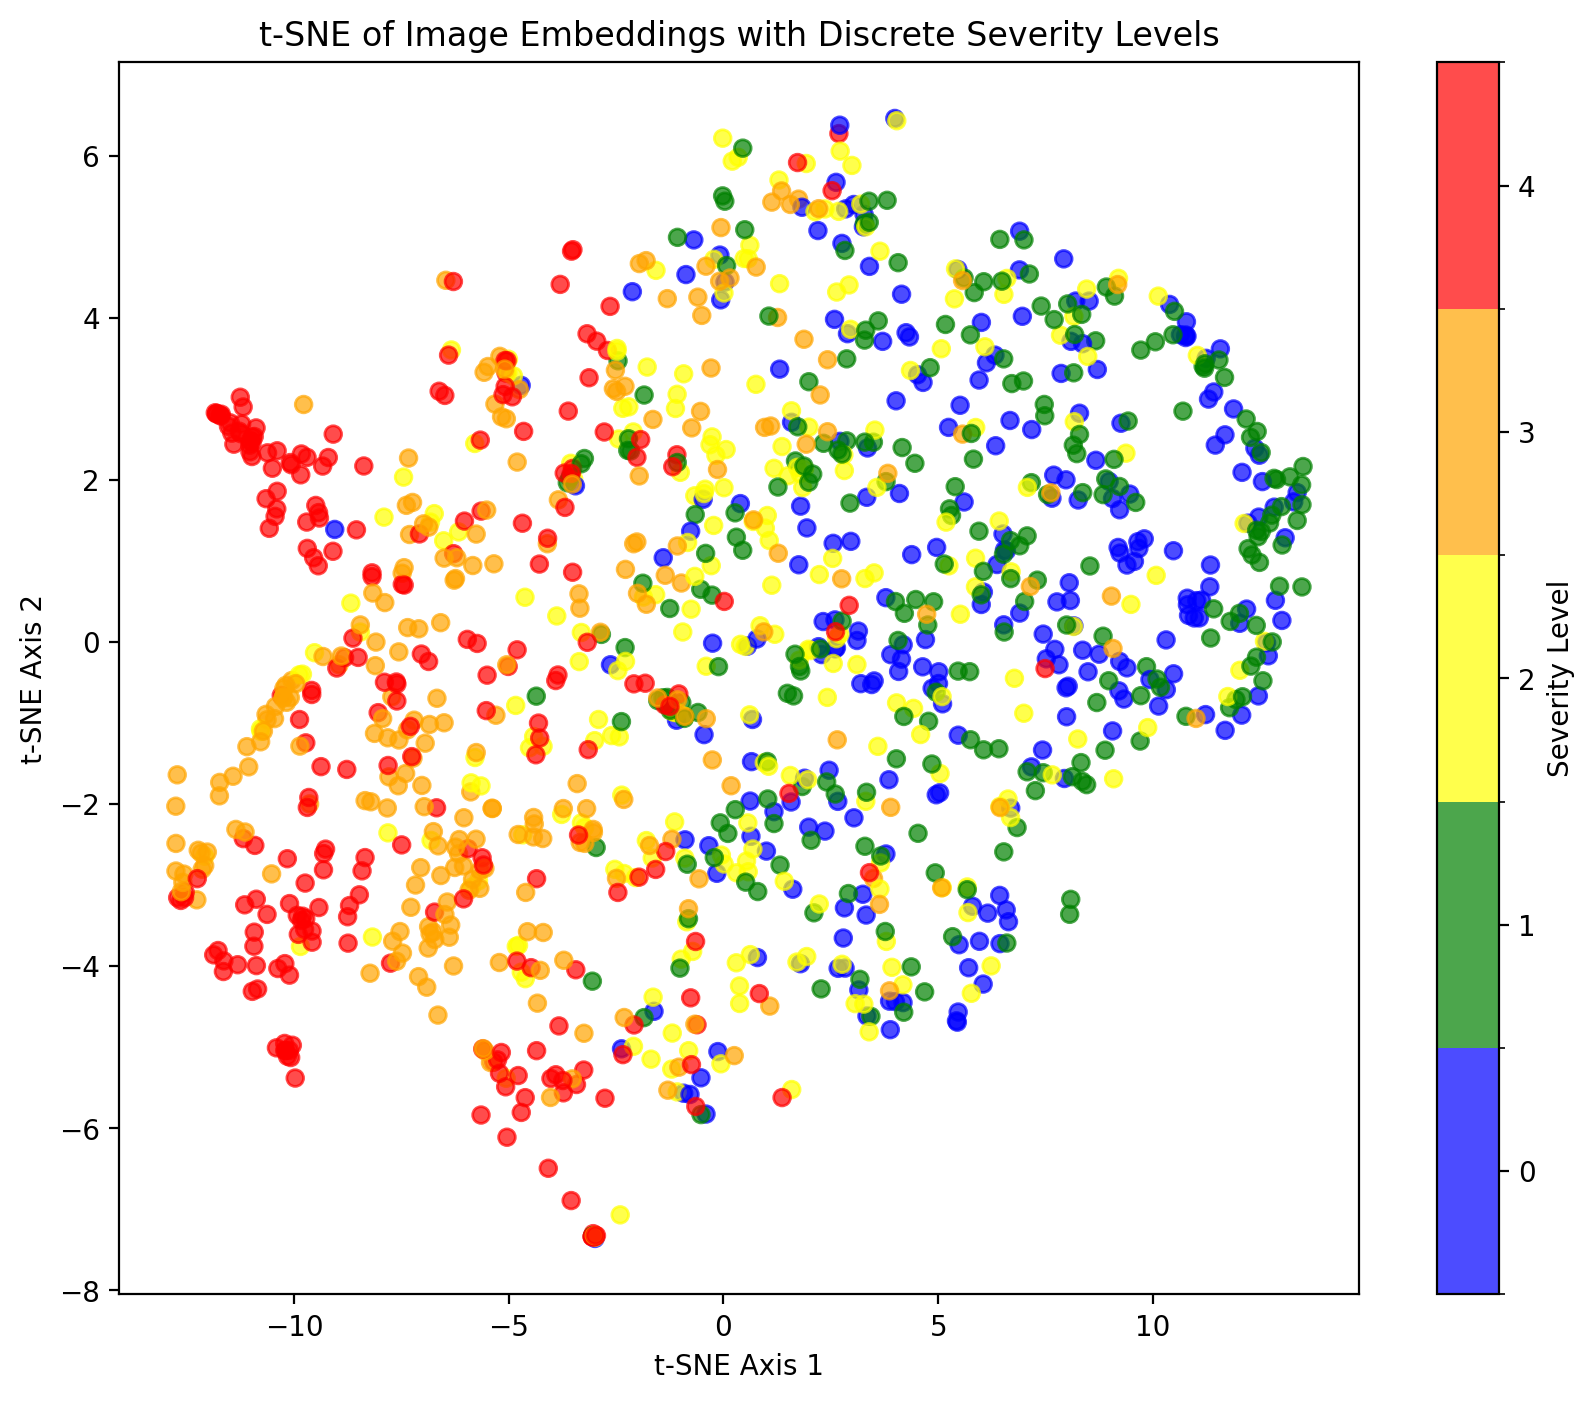

In [134]:
for FOLD in CFG.train_folds:
    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_train_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=CFG.workers,
            pin_memory=True,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER
    model = create_model()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader),
        )
    
    loss_criterion = nn.CrossEntropyLoss()

    # TRAIN FOLD
    best_score = 0
    
    wandb.run.tags = [f"fold_{FOLD}"]
    
    for epoch in range(0, CFG.epochs):
        train_loss, train_lr, train_auc, train_accuracy, train_precision = train_epoch(CFG, model, train_loader, loss_criterion, optimizer, scheduler, epoch)

        val_loss, val_auc, val_accuracy, val_precision = evaluate_model(CFG, model, valid_loader, loss_criterion, epoch)
        
        # Log metrics to wandb
        wandb.log({
            'train_loss': train_loss,
            'train_auc': train_auc,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'val_loss': val_loss,
            'val_auc': val_auc,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'learning_rate': train_lr[-1]  # Log the last learning rate of the epoch
        })

        if (val_accuracy > best_score):
            print(f"{style.GREEN}New best score: {best_score:.4f} -> {val_accuracy:.4f}{style.END}")
            best_score = val_accuracy
            torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth'))
            

    # plot a tsne plot of all the images using embeddings from the model
    full_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transforms=val_transforms)
    loader = DataLoader(
        full_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )
    
    features, targets = get_embeddings(model, loader)
    plot_tsne(features, targets)

In [135]:
wandb.finish()

learning_rate,██▇▇▆▅▃▂▂▁▁
train_accuracy,▁▁▃▄▄▆▆▇███
train_auc,▁▁▄▅▆▆▇▇███
train_loss,██▆▅▅▄▃▂▂▁▁
train_precision,▁▁▂▄▄▅▆▇███
val_accuracy,▂▁▃▃▅▆▆▆███
val_auc,▂▁▁▃▆▆▇▇███
val_loss,▄▄█▃▂▂▂▃▁▁▁
val_precision,▁▂▂▄▅▇▆▇███
learning_rate,0.0
train_accuracy,0.55729
